## Inicialización

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

## Carga los datos

El conjunto de datos se almacena en la carpeta `/datasets/faces/` 
- La carpeta `final_files` con 7600 fotos 
- El archivo `labels.csv` con etiquetas, con dos columnas: `file_name` y `real_age` 
Dado que el número de archivos de imágenes es bastante elevado, se recomienda evitar leerlos todos a la vez, ya que esto consumiría muchos recursos computacionales. Te recomendamos crear un generador con ImageDataGenerator. Este método se explicó en el capítulo 3, lección 7 de este curso.

El archivo de etiqueta se puede cargar como un archivo CSV habitual.

In [2]:
labels = pd.read_csv('../datasets/faces/labels.csv')
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [3]:
train_datagen = ImageDataGenerator(
    # Normalizamos los datos con valores entre 0 y 1
            rescale=1 / 255
            )

train_datagen_flow = train_datagen.flow_from_dataframe(
    dataframe = labels,
    directory='/datasets/faces/final_files/',
    x_col="file_name", 
    y_col="real_age",
    class_mode="raw",
    target_size=(224,224),
    batch_size=32,
    seed=45965
    )

Found 7591 validated image filenames.


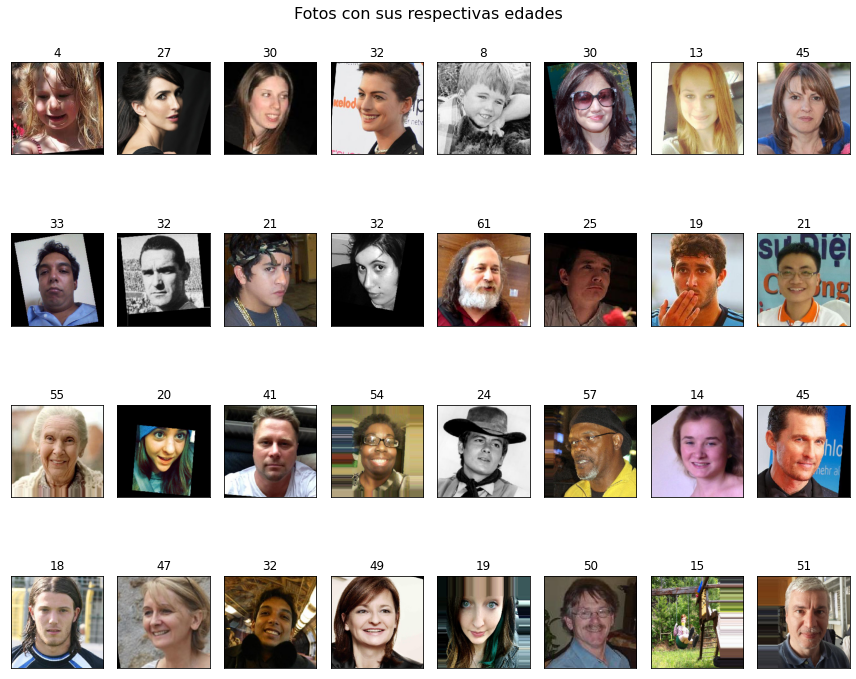

In [4]:
# Veamos las imágenes de un batch de nuestro datagen
features, target = next(train_datagen_flow)

# Y veamos 32 imágenes
fig = plt.figure(figsize=(12,12))
for i in range(32):
    fig.add_subplot(4, 8, i+1)
    plt.imshow(features[i])
    plt.title(f'{target[i]}')
# Removemos el eje y colocamos las imágenes más cerca entre sí para una vista más compacta
    plt.xticks([])
    plt.yticks([])
    plt.suptitle('Fotos con sus respectivas edades',  y=0.9,fontsize=16)
    plt.tight_layout()

Al parecer nuestro dataset contiene muvhas caras. Algunas están rotadas con la intención de enderezar la cara. También nos encontramos con muchas fotos que fueron editadas cerca de los bordes dando esas lineas verticales y horizontales que siguen el color de la imágen. Y no hablemos de la penúltima imágen... 

## EDA

Veamos la distribución de edades de las imágenes en todos los datos.

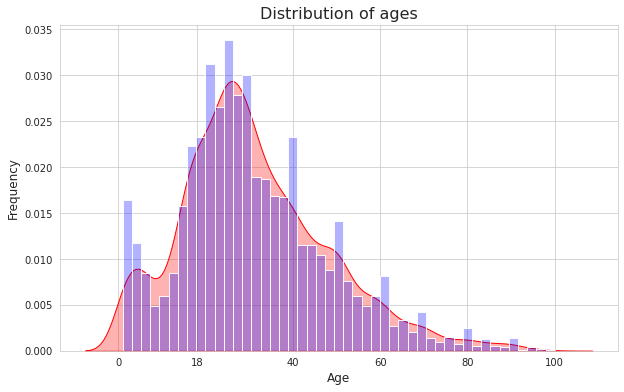

In [5]:
plt.figure(figsize=(10, 6))
sns.set_style('whitegrid')
sns.kdeplot(labels['real_age'], color='r', fill=True, alpha=0.3)
sns.histplot(labels['real_age'], color='b', alpha=0.3, stat='density')

# Marcamos un tick en 18 en vez de 20 ya que es una edad crucial en nuestro caso
plt.xticks([0, 18, 40, 60, 80, 100])
plt.xlabel('Age', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of ages', fontsize=16)
plt.show()

Veamos lo mismo pero en el batch que obtuvimos!

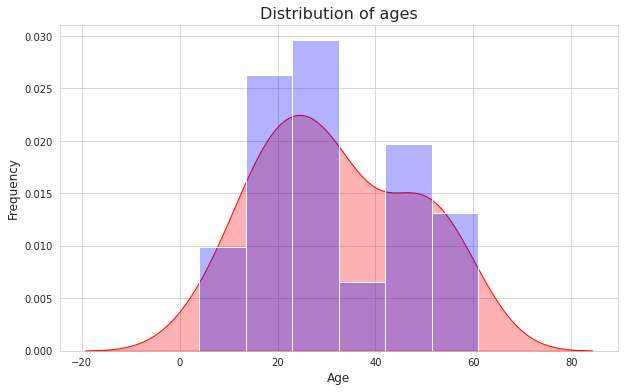

In [6]:
plt.figure(figsize=(10, 6))
sns.set_style('whitegrid')
sns.kdeplot(target, color='r', fill=True, alpha=0.3)
sns.histplot(target, color='b', alpha=0.3, stat='density')
plt.xlabel('Age', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of ages', fontsize=16)
plt.show()

### Conclusiones

Notamos unas grandes diferencias entre los datos totales y nuestro batch de imágenes. Si bien conservamos que en ambos gráficos las edades cercanas a 20 son las más comunes, no tenemos una cantidad representativa de edades menores de 10 ni cercanas a 40. También podemos notar como tenemos una cantidad demasiado alta de edades cercanas a los 60 pero ninguna superior.

## Modelado

Define las funciones necesarias para entrenar tu modelo en la plataforma GPU y crea un solo script que las contenga todas junto con la sección de inicialización.

Para facilitar esta tarea, puedes definirlas en este notebook y ejecutar un código listo en la siguiente sección para componer automáticamente el script.

Los revisores del proyecto también verificarán las definiciones a continuación, para que puedan comprender cómo construiste el modelo.

In [7]:
def load_train(path):
    
    datagen = ImageDataGenerator(
        horizontal_flip=True,
        channel_shift_range=0.1,
        validation_split=0.25,
        rescale=(1/255)
    )

    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'),
        directory=(path + 'final_files/'),
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=7489
    )
    return train_datagen_flow

In [8]:
def load_test(path):
    datagen = ImageDataGenerator(
        horizontal_flip=True,
        validation_split=0.25,
        rescale=(1/255)
    )

    test_datagen_flow = datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'),
        directory=(path + 'final_files/'),
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=4567
    )
    return test_datagen_flow

In [9]:
def create_model(input_shape):
    
    optimizer = Adam(lr=0.0003)

    backbone = ResNet50(
        input_shape=input_shape, weights='imagenet', include_top=False
    )

    model = Sequential()
    # --------------------------------------------------    
    model.add(backbone)
    # --------------------------------------------------    
    model.add(Dropout(0.2))
    # --------------------------------------------------    
    model.add(GlobalAveragePooling2D())
    # --------------------------------------------------
    model.add(Dense(1,activation='relu'))

    model.compile(
        optimizer= optimizer,
        loss= 'mean_absolute_error',
        metrics= ['mae']
    )
    return model

In [10]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
    validation_data=test_data,
    batch_size=batch_size,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    verbose=2)
    
    return model

## Prepara el script para ejecutarlo en la plataforma GPU

Una vez que hayas definido las funciones necesarias, puedes redactar un script para la plataforma GPU, descargarlo a través del menú "File|Open..." (Archivo|Abrir) y cargarlo más tarde para ejecutarlo en la plataforma GPU.

Nota: el script debe incluir también la sección de inicialización. A continuación se muestra un ejemplo.

In [54]:
# prepara un script para ejecutarlo en la plataforma GPU

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### El resultado

Coloca el resultado de la plataforma GPU como una celda Markdown aquí.

Se omitieron los mensajes internos de TensorFlow ya que no aportaban información respecto al entrenamiento o rendimiento del modelo. También se editó ligeramente el texto para mayor claridad de lectura.

*Train for 178 steps, validate for 60 steps*
  
**Epoch 1/20**
  
178/178 - 68s - loss: 10.3698 - mae: 10.3688 - val_loss: 15.1354 - val_mae: 15.1488
  
**Epoch 2/20**
  
178/178 - 43s - loss: 8.0192 - mae: 8.0189 - val_loss: 40.6160 - val_mae: 40.6072
  
**Epoch 3/20**
  
178/178 - 43s - loss: 7.0258 - mae: 7.0257 - val_loss: 15.2109 - val_mae: 15.2148
  
**Epoch 4/20**
  
178/178 - 44s - loss: 6.5011 - mae: 6.5009 - val_loss: 10.2717 - val_mae: 10.3217
  
**Epoch 5/20**
  
178/178 - 42s - loss: 5.9891 - mae: 5.9885 - val_loss: 8.2329 - val_mae: 8.2544
  
**Epoch 6/20**
  
178/178 - 42s - loss: 5.6633 - mae: 5.6632 - val_loss: 7.4706 - val_mae: 7.4730
  
**Epoch 7/20**
  
178/178 - 42s - loss: 5.2523 - mae: 5.2520 - val_loss: 8.0387 - val_mae: 8.0487
  
**Epoch 8/20**
  
178/178 - 42s - loss: 4.9804 - mae: 4.9804 - val_loss: 7.6306 - val_mae: 7.6402
  
**Epoch 9/20**
  
178/178 - 42s - loss: 4.6878 - mae: 4.6874 - val_loss: 8.7614 - val_mae: 8.7837
  
**Epoch 10/20**
  
178/178 - 43s - loss: 4.5677 - mae: 4.5675 - val_loss: 8.2150 - val_mae: 8.2408
  
**Epoch 11/20**
  
178/178 - 43s - loss: 4.3312 - mae: 4.3308 - val_loss: 6.8217 - val_mae: 6.8497
  
**Epoch 12/20**
  
178/178 - 43s - loss: 4.1284 - mae: 4.1284 - val_loss: 6.4669 - val_mae: 6.4727
  
**Epoch 13/20**
  
178/178 - 44s - loss: 3.9046 - mae: 3.9042 - val_loss: 7.3706 - val_mae: 7.3926
  
**Epoch 14/20**
  
178/178 - 42s - loss: 3.7864 - mae: 3.7865 - val_loss: 7.3068 - val_mae: 7.3550
  
**Epoch 15/20**
  
178/178 - 42s - loss: 3.6724 - mae: 3.6724 - val_loss: 6.2849 - val_mae: 6.2940
  
**Epoch 16/20**
  
178/178 - 42s - loss: 3.5043 - mae: 3.5042 - val_loss: 6.9059 - val_mae: 6.9306
  
**Epoch 17/20**
  
178/178 - 42s - loss: 3.4582 - mae: 3.4578 - val_loss: 6.7444 - val_mae: 6.7774
  
**Epoch 18/20**
  
178/178 - 42s - loss: 3.3376 - mae: 3.3374 - val_loss: 6.3057 - val_mae: 6.3051
  
**Epoch 19/20**
  
178/178 - 42s - loss: 3.2237 - mae: 3.2237 - val_loss: 6.3024 - val_mae: 6.3201
  
**Epoch 20/20**
  
178/178 - 42s - loss: 3.0830 - mae: 3.0831 - val_loss: 6.3262 - val_mae: 6.3428
  
60/60 - 10s - loss: 6.3814 - mae: 6.4046
  
Test MAE: 6.4046

## Conclusiones

Terminamos entonces el entrenamiento de nuestro modelo. Entonces, el modelo es apto para nuestro cliente? En pocas palabras si, pero hay que tomar un par de consideraciones. Al ser una red relativamente simple el proceso de entrenamiento es viable para una empresa de mediana escala. En la última época el modelo tardó 10 segundos en realizar 60 predicciones por lo que también se puede implementar en producción y dar predicciones con el tiempo promedio en el que una persona realiza sus compras.
  
Ahora, respecto a la viabilidad para realizar predicciones correctas. Al ver arriba nos encontramos con que el Error Absoluto Medio es de 6.4 lo que implica que (al menos según la métrica) existe la posibilidad de categorizar a alguien como mayor de edad cuando ésta persona tiene por ejemplo 14 años (técnicamente 13 años pero tengo mis dudas). Para poder realizar afirmaciones contundentes habría que realizar pruebas más exhaustivas sobre el modelo ya entrenado con fotografías de personas menores a 18 años. El detalle importante es que nuestra base de datos no posee una gran cantidad de éstas, ciertamente tiene muchas de personas mayores (o iguales) de 18 años lo cual si le da el conocimiento como para reconocer a alguien mayor, no podemos extrapolar al punto de distinguir a alguien que no lo es.
  
Una buena forma de implementar el modelo sería con un algoritmo posterior al modelo que se encargue de tomar las predicciones y en base a los valores encontrados determinar si es necesario notificar al vendedor para que éste verifique la edad del cliente con algún tipo de documento. De ésta forma el vendedor no tiene que estar alerta para analizar a cada cliente y solo atento a algo simple como una luz o mensaje en una pantalla que le indique cuándo accionar.